Data after cleaning: 602 rows

Buy signals (RSI < 30): 28
Sell signals (RSI > 70): 124
Position changes: 87
Unique positions: [ 0. -1.  1.]


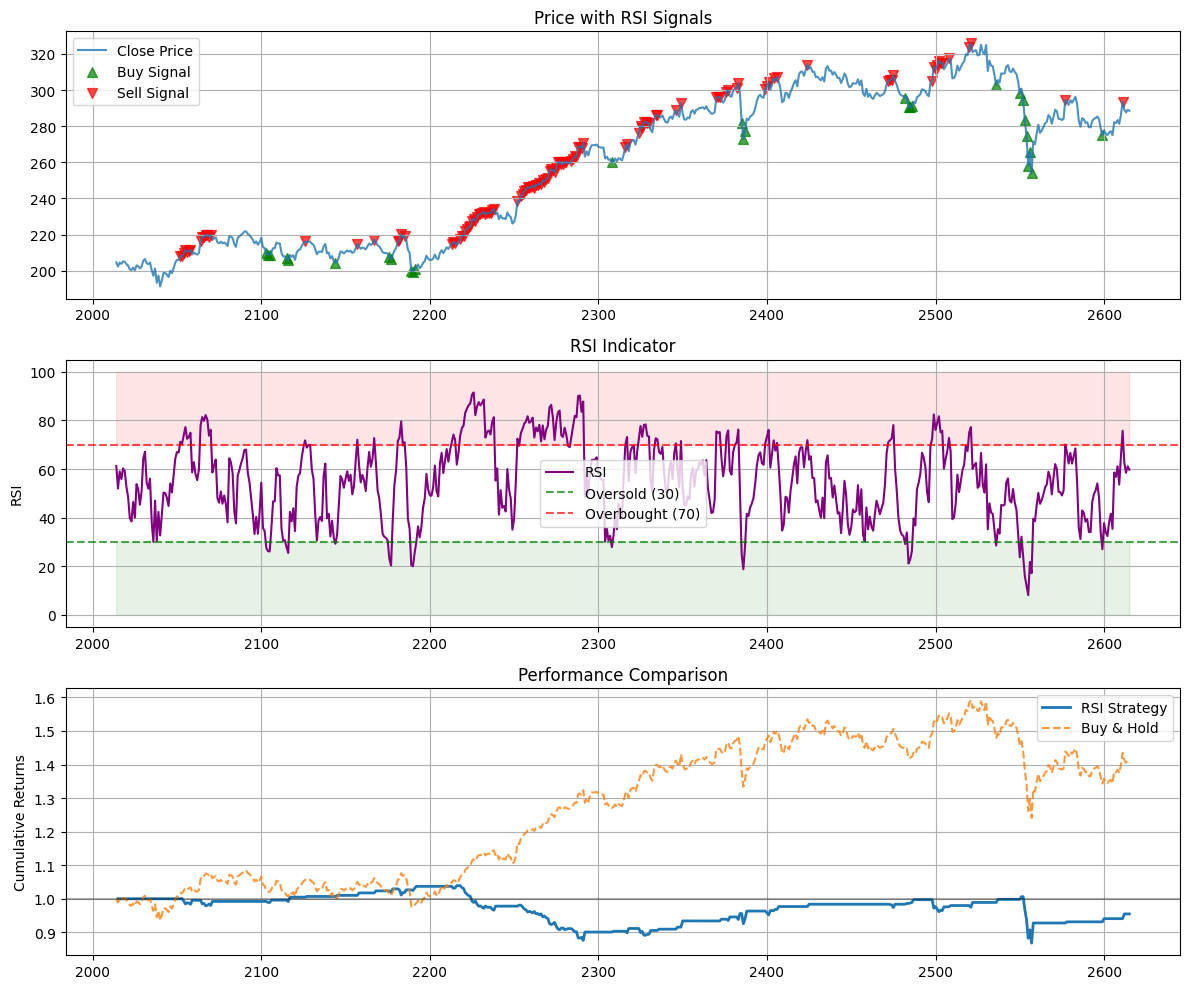


=== PERFORMANCE RESULTS ===
RSI Strategy Final Return: 0.9548x (-4.52%)
Buy & Hold Final Return: 1.4100x (41.00%)
Strategy vs Buy & Hold: -32.28%
Max Drawdown: -16.48%

=== SAMPLE DATA ===
       Close      rsi  signal  position  returns  strategy_returns
2014  204.65  61.2557       0       0.0      NaN               NaN
2015  202.35  51.9690       0       0.0  -0.0112              -0.0
2016  204.60  58.9874       0       0.0   0.0111               0.0
2017  203.85  55.8486       0       0.0  -0.0037              -0.0
2018  205.20  60.2424       0       0.0   0.0066               0.0
2019  205.00  59.2347       0       0.0  -0.0010              -0.0
2020  203.70  52.6320       0       0.0  -0.0063              -0.0
2021  202.85  48.5493       0       0.0  -0.0042              -0.0
2022  200.75  39.7576       0       0.0  -0.0104              -0.0
2023  200.40  38.4197       0       0.0  -0.0017              -0.0
2024  201.75  46.4413       0       0.0   0.0067               0.0
2025  

In [1]:
import pandas as pd
import rhoa
import matplotlib.pyplot as plt

# Load your price data
df = rhoa.data.import_sheet("https://docs.google.com/spreadsheets/d/1To-jrrwNBP1XbC4g7LOFdruBKAOdfe-zW3dJrBEkjC4/edit?gid=0#gid=0")[2000:]

# Compute RSI
df["rsi"] = df["Close"].indicators.rsi()

# Remove NaN values
df = df.dropna()

print(f"Data after cleaning: {df.shape[0]} rows")

# === Simple RSI Strategy ===
# Buy when RSI < 30 (oversold)
# Sell when RSI > 70 (overbought)
df["signal"] = 0
df.loc[df["rsi"] < 30, "signal"] = 1   # Buy signal
df.loc[df["rsi"] > 70, "signal"] = -1  # Sell signal

# Position (shifted to avoid lookahead bias)
df["position"] = df["signal"].shift().fillna(0).ffill()

# Debug info
buy_signals = (df["signal"] == 1).sum()
sell_signals = (df["signal"] == -1).sum()
position_changes = (df["position"] != df["position"].shift()).sum()

print(f"\nBuy signals (RSI < 30): {buy_signals}")
print(f"Sell signals (RSI > 70): {sell_signals}")
print(f"Position changes: {position_changes}")
print(f"Unique positions: {df['position'].unique()}")

# Returns calculation
df["returns"] = df["Close"].pct_change()
df["strategy_returns"] = df["position"] * df["returns"]
df["cumulative_returns"] = (1 + df["strategy_returns"]).cumprod()

# Buy & Hold comparison
df["buy_hold"] = df["Close"] / df["Close"].iloc[0]

# Plot results
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Price chart with positions
axes[0].plot(df.index, df["Close"], label="Close Price", alpha=0.8)
buy_points = df[df["signal"] == 1]
sell_points = df[df["signal"] == -1]
axes[0].scatter(buy_points.index, buy_points["Close"], color='green', marker='^', s=50, label='Buy Signal', alpha=0.7)
axes[0].scatter(sell_points.index, sell_points["Close"], color='red', marker='v', s=50, label='Sell Signal', alpha=0.7)
axes[0].set_title("Price with RSI Signals")
axes[0].legend()
axes[0].grid(True)

# RSI chart
axes[1].plot(df.index, df["rsi"], label="RSI", color='purple')
axes[1].axhline(y=30, color='green', linestyle='--', alpha=0.7, label="Oversold (30)")
axes[1].axhline(y=70, color='red', linestyle='--', alpha=0.7, label="Overbought (70)")
axes[1].fill_between(df.index, 0, 30, alpha=0.1, color='green')
axes[1].fill_between(df.index, 70, 100, alpha=0.1, color='red')
axes[1].set_title("RSI Indicator")
axes[1].set_ylabel("RSI")
axes[1].legend()
axes[1].grid(True)

# Performance comparison
axes[2].plot(df.index, df["cumulative_returns"], label="RSI Strategy", linewidth=2)
axes[2].plot(df.index, df["buy_hold"], label="Buy & Hold", linestyle='--', alpha=0.8)
axes[2].axhline(y=1, color='black', linestyle='-', alpha=0.3)
axes[2].set_title("Performance Comparison")
axes[2].set_ylabel("Cumulative Returns")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Performance metrics
final_return = df["cumulative_returns"].iloc[-1]
buy_hold_return = df["buy_hold"].iloc[-1]
max_drawdown = (df["cumulative_returns"] / df["cumulative_returns"].cummax() - 1).min()

print(f"\n=== PERFORMANCE RESULTS ===")
print(f"RSI Strategy Final Return: {final_return:.4f}x ({(final_return-1)*100:.2f}%)")
print(f"Buy & Hold Final Return: {buy_hold_return:.4f}x ({(buy_hold_return-1)*100:.2f}%)")
print(f"Strategy vs Buy & Hold: {((final_return/buy_hold_return-1)*100):+.2f}%")
print(f"Max Drawdown: {max_drawdown*100:.2f}%")

# Show some sample trades
print(f"\n=== SAMPLE DATA ===")
sample_cols = ['Close', 'rsi', 'signal', 'position', 'returns', 'strategy_returns']
print(df[sample_cols].head(15).round(4))